In [1]:
import numpy as np
import matplotlib.pyplot as plt
from extra_packages import OutputInterface as oi
from extra_packages import sperhical_expansion as se
import SFALinearPulse as sfa_lin
from matplotlib.colors import LogNorm
from itertools import repeat
import matplotlib as mpl

# Matplotlib asthetics
major = 7.5
minor = 5
width = 1.25
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc("axes", labelsize=16) # 18
plt.rc("xtick", labelsize=14, top=True, direction="in")
plt.rc("ytick", labelsize=14, right=True, direction="in")
plt.rc("axes", titlesize=18)
plt.rc("legend", fontsize=14)
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.linewidth'] = width
plt.rcParams['xtick.minor.width'] = width
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.minor.width'] = width
plt.rcParams['ytick.major.width'] = width
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

In [2]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
import multiprocessing

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default

pool = multiprocessing.Pool(processes=cpus)

In [144]:
output = oi.OutputInterface('output_files/CHBrClF1.out') #H2O2_mod.out
Ip = abs(output.saved_orbitals[output.HOMO][0])
kappa = np.sqrt(2*Ip)
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2
N = 2

#gto_coeffs = np.array(output.output_GTOs())

In [132]:
plot_list = np.linspace(0.1, 14, 75)
#plot_list = np.linspace(0.1, 15, 75)
f_lms = se.laplace_several_r(output.eval_orbital_spherical, plot_list, 12, orbital_nr=output.HOMO) ## 10, 7.5, 10.0

### H2O2 ###!!!!!!!!!!!!!!!
'''r_list = np.linspace(3.2, 3.6, 50)
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 8, Ip, orbital_nr=output.HOMO, ## 8 ##
                             threshold=1e-3, normalized=False)'''

## CHBrClF ##
r_list = np.linspace(8.0, 10.0, 50)
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 12, Ip, orbital_nr=output.HOMO, ## 8 ##
                             threshold=1e-4, normalized=False)

## Fencone ##
'''r_list = np.linspace(7.5, 8.5, 10) # 7.0, 7.2 # 7.5 8.0 # 8.0, 9.0 # 9, 10 # 6.0, 7.5 #!! 7.5, 12.5 !!# 7.0 8.5 #
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 8, Ip, orbital_nr=output.HOMO, ## 8 ##
                             threshold=1e-4, normalized=False)'''

## Camphor ##
'''r_list = np.linspace(8, 12, 10) # 7.5, 12.5 #
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 8, Ip, orbital_nr=output.HOMO, ## 8 ##
                             threshold=1e-3, normalized=False)'''

# Get coefficients for other enantiomer via reflection in xz-plane: c_lm -> (-1)^(m)c_l-m
clm_array2 = np.copy(clm_array)
for l in range(1, len(clm_array[1])):
    clm_array2[0, l, :] = clm_array[1, l, :]
    clm_array2[1, l, :] = clm_array[0, l, :]
#clm_array2[0, :, 1] = clm_array[1, :, 1]

#clm_array /= np.sum(np.abs(clm_array)**2)
#clm_array2 /= np.sum(np.abs(clm_array2)**2)

for sgn in range(2):
    for l in range(clm_array.shape[1]):
        for m in range(0, l + 1):
            clm_array2[sgn, l, m] *= (-1)**m

#all_coeffs = np.array([np.array(gto_coeffs), np.array(clm_array)], dtype='object')

Evaluating at r=10.0000 	 Nr. 50/50
Now fitting!
Done!


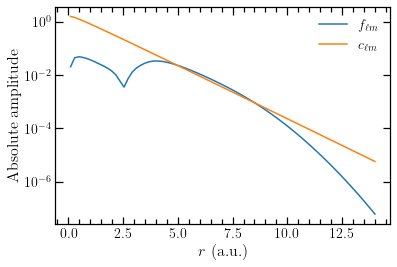

In [133]:
def asymp(r, clm):
    return clm * r**(1/kappa - 1) * np.exp(-kappa*r)

sgn, l, m = 0, 1, 1
plt.figure(facecolor='white')
plt.plot(plot_list, np.abs(f_lms[:, sgn, l, m]), label=r'$f_{\ell m}$')
plt.plot(plot_list, np.abs(asymp(plot_list, clm_array[sgn, l, m])), label=r'$c_{\ell m}$')
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.legend(frameon=False)
plt.yscale('log')
plt.minorticks_on()
plt.show()

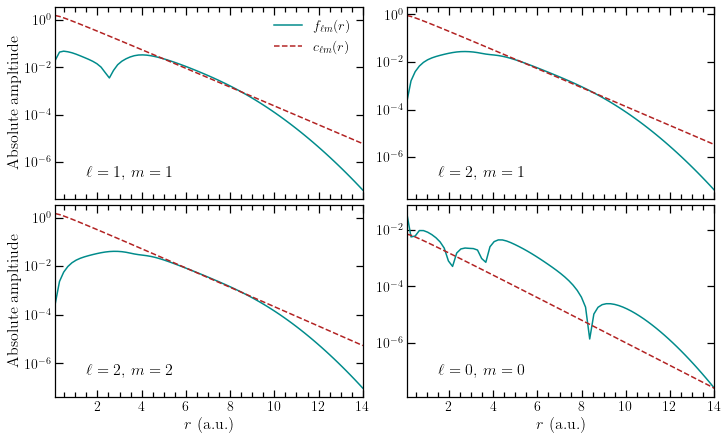

In [134]:
fig, axs = plt.subplots(ncols=2, nrows=2, constrained_layout=True, facecolor='white', sharex='all', figsize=(10, 6))
lm_lst = [[[1, 1], [2, 1]],
          [[2, 2], [0, 0]]]
for i in range(2):
    for j in range(2):
        l, m = lm_lst[i][j]
        axs[i, j].plot(plot_list, np.abs(f_lms[:, 0, l, m]), label=r'$f_{\ell m}(r)$', c='darkcyan')
        axs[i, j].plot(plot_list, np.abs(asymp(plot_list, clm_array[0, l, m])), label=r'$c_{\ell m}(r)$', c='firebrick', ls='--')
        axs[i, j].set_yscale('log')
        axs[i, j].set_xlim(plot_list[0], plot_list[-1])
        axs[i, j].minorticks_on()
        axs[i, j].text(0.1, 0.1, f'$\ell={l}$, $m={m}$', horizontalalignment='left', verticalalignment='bottom',
                       transform=axs[i, j].transAxes, fontsize=16)
        if j == 0:
            axs[i, j].set_ylabel('Absolute ampltiude')
            if i == 0:
                axs[i, j].legend(frameon=False)
        if i == 1:
            axs[i, j].set_xlabel('$r$ (a.u.)')
plt.savefig('expansion.eps', format='eps')

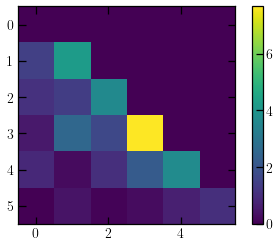

1.1850944513118922


In [135]:
plt.imshow(np.abs(clm_array[0])**2, cmap='viridis')
plt.colorbar()
plt.show()
print(np.abs(clm_array[0, 2, 1]))

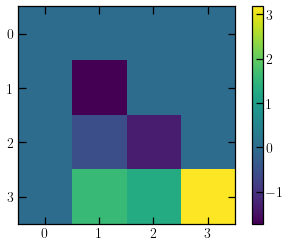

1.1740332368537199


In [130]:
plt.imshow(np.imag(clm_array[0]), cmap='viridis')
plt.colorbar()
plt.show()
print(np.abs(clm_array[0, 2, 1]))

## Save coefficients

In [98]:
# Print out the coefficients
clm_lst = se.convert_clm_array_to_list(clm_array)
print(np.sqrt(len(clm_lst)) - 1)
#np.savetxt('clm_coeffs_re.txt', np.real(clm_lst))
#np.savetxt('clm_coeffs_im.txt', np.imag(clm_lst))
coeffs = []
for re, im in zip(np.real(clm_lst), np.imag(clm_lst)):
    coeffs.append([re, im])
coeffs = np.array(coeffs)
np.savetxt('H2O2_coeffs.txt', coeffs)

3.0


## Plot iso-surfaces

In [106]:
from mayavi import mlab
l = 10
n = 50
iso = 0.01
x, y, z = np.mgrid[-l:l:n*1j, -l:l:n*1j, -l:l:n*1j]
mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
orbital = output.eval_orbital(x, y, z)

mlab.contour3d(orbital, contours=[iso], transparent=False, color=(1, 0, 0))
mlab.contour3d(orbital, contours=[-iso], transparent=False, color=(0, 0, 1))
mlab.show()

In [137]:
from mayavi import mlab
l = 10
n = 75
x, y, z = np.mgrid[-l:l:n * 1j, -l:l:n * 1j, -l:l:n * 1j]
asymp = np.real(se.eval_asymptotic_cart(x, y, z, clm_array, Ip))
iso = 0.01
mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
mlab.contour3d(asymp, contours=[iso], transparent=False, color=(1, 0, 0))
mlab.contour3d(asymp, contours=[-iso], transparent=False, color=(0, 0, 1))
mlab.show()

## Calculate PMDs

In [138]:
dp = 4. / 200
px_lst = np.arange(0, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, 2, np.pi/2, 'asymp')
M_grd = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))
M_grd2 = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array2))))
M_sqr = np.abs(np.flip(M_grd, 0))**2
M_sqr2 = np.abs(np.flip(M_grd2, 0))**2
print('Done!')

Done!


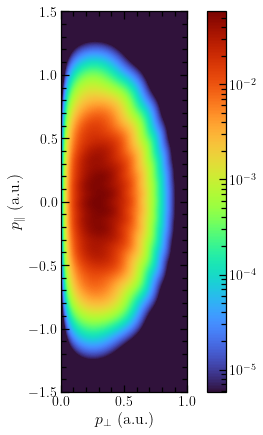

In [139]:
PMD = M_sqr2
plt.figure(facecolor='white', figsize=(7, 7))
plt.imshow(PMD, interpolation='bicubic', cmap='turbo',
                 norm=LogNorm(vmax=np.max(PMD), vmin=np.max(PMD)*1e-4),
                 extent=(0, 1, -1.5, 1.5))
plt.xlabel(r'$p_\perp$ (a.u.)')
plt.ylabel(r'$p_\parallel$ (a.u.)')
plt.colorbar()
plt.minorticks_on()
plt.show()

In [26]:
Ip

0.3745

## OAM-resolved PMDs

In [140]:
OAM_grd1 = []
OAM_grd2 = []
OAM_lst = [-2, -1, 1, 2]

dp = 4. / 200 #450
px_lst = np.arange(0.01, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

for OAM in OAM_lst:
    print(f'Doing OAM={OAM}')
    sfa.OAM = OAM
    M_l = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))
    OAM_grd1.append(M_l)
    M_l = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array2))))
    OAM_grd2.append(M_l)
OAM_grd_tot = [OAM_grd1, OAM_grd2]

Doing OAM=-2
Doing OAM=-1
Doing OAM=1
Doing OAM=2


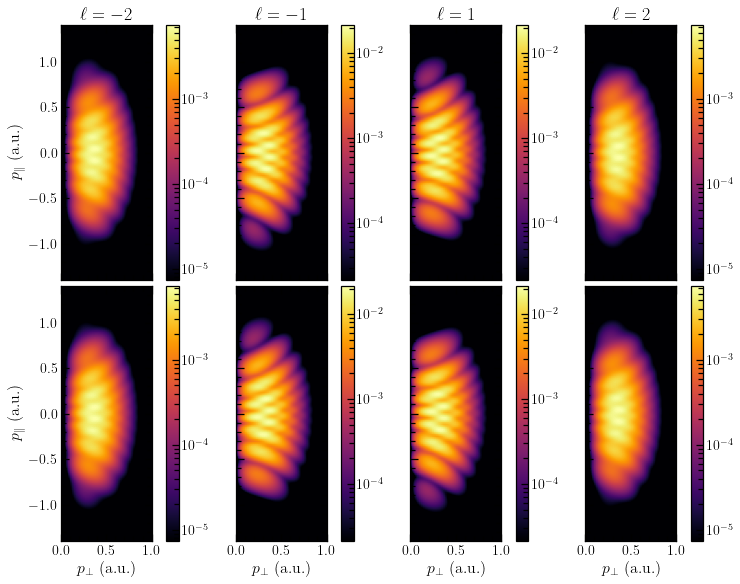

In [142]:
fig, axs = plt.subplots(2, len(OAM_lst), facecolor='white', figsize=(10, 8), constrained_layout=True, sharey='all', sharex='all')
for i in range(2):
    for j in range(len(OAM_lst)):
        im = axs[i, j].imshow(np.abs(OAM_grd_tot[i][j])**2, cmap='inferno',
                              norm=LogNorm(vmax=np.max(np.abs(OAM_grd_tot[i][j])**2), vmin=np.max(np.abs(OAM_grd_tot[i][j])**2)*1e-3),
                              extent=(0, 1, -1.4, 1.4))
        plt.colorbar(im, ax=axs[i, j], shrink=1)
        axs[i, j].minorticks_on()
        if i == 0:
            axs[i, j].set_title(f'$\ell={OAM_lst[j]}$')
        if i == 1:
            axs[i, j].set_xlabel(r'$p_\perp$ (a.u.)')
        if j == 0:
            axs[i, j].set_ylabel(r'$p_\parallel$ (a.u.)')
#plt.show()

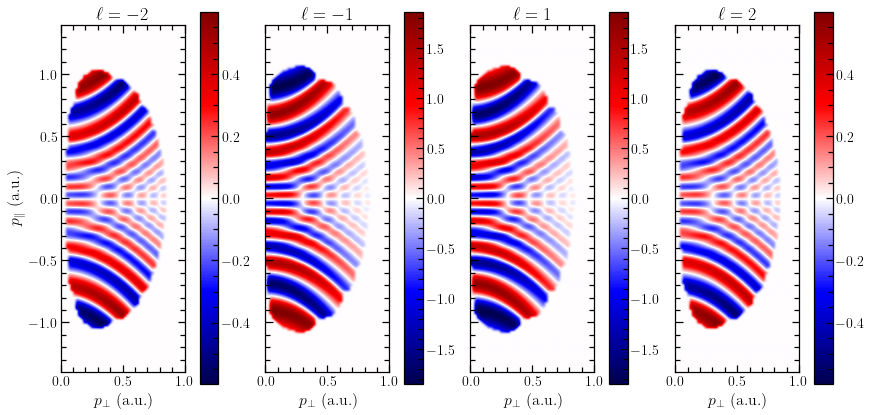

In [143]:
num = len(OAM_lst)
threshold = 0.125e-2
fig, axs = plt.subplots(1, num, facecolor='white', figsize=(12, 15), constrained_layout=True, sharey='all', sharex='all')
count = 0
for ax, Ml1, Ml2, l in zip(axs, OAM_grd_tot[0], OAM_grd_tot[1], OAM_lst):
    Ml1 = np.abs(Ml1)**2
    Ml2 = np.abs(Ml2)**2
    #Ml2 = np.flip(Ml2, 0)
    PEVD = 2*((Ml1 - Ml2)/(Ml1 + Ml2) + 1e-15)
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Ml1 > np.max(Ml1 * threshold)
    filter_list2 = Ml2 > np.max(Ml2 * threshold)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    im = ax.imshow(PEVD, cmap='seismic', norm=MidpointNormalize(np.min(PEVD), np.max(PEVD)), extent=(0, 1, -1.4, 1.4), interpolation='bicubic')
    cbar = plt.colorbar(im, ax=ax)
    cbar.minorticks_on()
    ax.set_xlabel(r'$p_\perp$ (a.u.)')
    ax.minorticks_on()
    if count == 0:
        ax.set_ylabel(r'$p_\parallel$ (a.u.)')
    ax.set_title(f'$\ell={OAM_lst[count]}$')
    count += 1
plt.show()

0.6551810335402758
0.7213555662790404
0.7213555646982406


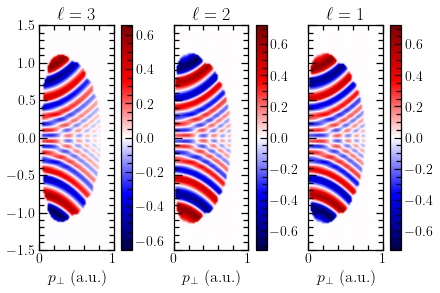

In [125]:
num = len(OAM_lst)
threshold = 0.125e-2
C = 1
fig, axs = plt.subplots(1, 3, facecolor='white', figsize=(6, 10), constrained_layout=True, sharey='all', sharex='all')
for ax, Ml1, Ml2, l in zip(axs,
                           [OAM_grd_tot[C][0], OAM_grd_tot[C][1], OAM_grd_tot[C][2]],
                           [OAM_grd_tot[C][-1], OAM_grd_tot[C][-2], OAM_grd_tot[C][-3]],
                           [3, 2, 1]):
    Ml1 = np.abs(Ml1)**2
    Ml2 = np.abs(Ml2)**2
    #Ml2 = np.flip(Ml2, 0)
    PEVD = 2*((Ml1 - Ml2)/(Ml1 + Ml2))
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Ml1 > np.max(Ml1 * threshold)
    filter_list2 = Ml2 > np.max(Ml2 * threshold)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    print(np.max(PEVD))
    im = ax.imshow(PEVD, cmap='seismic', norm=MidpointNormalize(np.min(PEVD), np.max(PEVD)), extent=(0, 1, -1.5, 1.5), interpolation='bicubic')
    cbar = plt.colorbar(im, ax=ax)
    cbar.minorticks_on()
    ax.set_xlabel(r'$p_\perp$ (a.u.)')
    ax.minorticks_on()
    if count == 0:
        ax.set_ylabel(r'$p_\parallel$ (a.u.)')
    ax.set_title(f'$\ell={l}$')
    count += 1
plt.show()

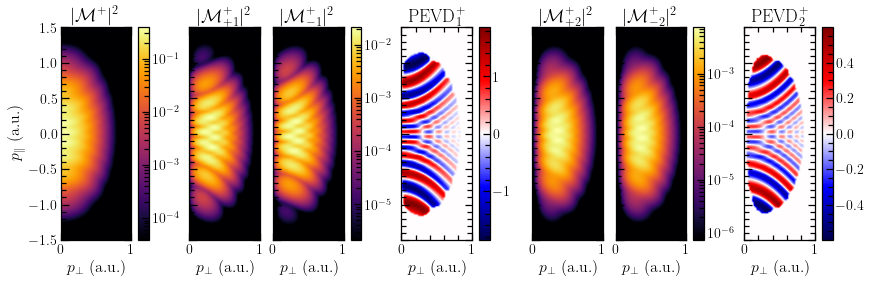

In [145]:
PEVD_lst = []
idx_lst = [[1, 2], [0, -1]]
for idx in idx_lst:
    Ml1 = np.abs(OAM_grd1[idx[0]])**2
    Ml2 = np.abs(OAM_grd2[idx[0]])**2
    #Ml1 = np.flip(Ml1, 0)
    PEVD = 2*((Ml1 - Ml2)/(Ml1 + Ml2))
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Ml1 > np.max(Ml1 * threshold)
    filter_list2 = Ml2 > np.max(Ml2 * threshold)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    PEVD_lst.append(PEVD)

cmap = 'inferno'

fig, ax = plt.subplots(1, 7, figsize=(12, 4), facecolor='white', sharey='all', constrained_layout=True)
im1 = ax[0].imshow(M_sqr, cmap=cmap, norm=LogNorm(vmax=np.max(M_sqr), vmin=np.max(M_sqr)*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[0].set_ylabel(r'$p_\parallel$ (a.u.)')
ax[0].set_title(r'$|\mathcal{M}^+|^2$')

im2 = ax[1].imshow(np.abs(OAM_grd1[1])**2, cmap=cmap, norm=LogNorm(vmax=np.max(np.abs(OAM_grd1[1])**2), vmin=np.max(np.abs(OAM_grd1[1])**2)*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[1].set_title(r'$|\mathcal{M}^+_{+1}|^2$')

im3 = ax[2].imshow(np.abs(OAM_grd1[2])**2, cmap=cmap, norm=LogNorm(vmax=np.max(np.abs(OAM_grd1[2])**2), vmin=np.max(np.abs(OAM_grd1[2])**2)*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[2].set_title(r'$|\mathcal{M}^+_{-1}|^2$')

im4 = ax[3].imshow(np.real(PEVD_lst[0]), cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[3].set_title(r'$\text{PEVD}^+_1$')

im5 = ax[4].imshow(np.abs(OAM_grd1[0])**2, cmap=cmap, norm=LogNorm(vmax=np.max(np.abs(OAM_grd1[0])**2), vmin=np.max(np.abs(OAM_grd1[0])**2)*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[4].set_title(r'$|\mathcal{M}^+_{+2}|^2$')

im6 = ax[5].imshow(np.abs(OAM_grd1[-1])**2, cmap=cmap, norm=LogNorm(vmax=np.max(np.abs(OAM_grd1[-1])**2), vmin=np.max(np.abs(OAM_grd1[-1])**2)*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[5].set_title(r'$|\mathcal{M}^+_{-2}|^2$')

im7 = ax[6].imshow(np.real(PEVD_lst[1]), cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[6].set_title(r'$\text{PEVD}^+_2$')

aspect = 20
shrink = 5
fig.colorbar(im1, ax=ax[0], aspect=aspect, shrink=shrink)
fig.colorbar(im2, ax=ax[2], aspect=aspect, shrink=shrink)
cbar = fig.colorbar(im4, ax=ax[3], aspect=aspect, shrink=shrink)
cbar.minorticks_on()
fig.colorbar(im6, ax=ax[5], aspect=aspect, shrink=shrink)
cbar2 = fig.colorbar(im7, ax=ax[6], aspect=aspect, shrink=shrink)
cbar2.minorticks_on()

for axi in ax:
    axi.set_xlabel(r'$p_\perp$ (a.u.)')
    axi.minorticks_on()
np.max(PEVD_lst[0])
plt.savefig('fencone_aligned.png', dpi=350)

## ATI spectra

In [ ]:
sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, 10, np.pi/2, 'asymp')
E_lst = np.linspace(0, 0.5, 2)
sfa.OAM = 1
spec1_2 = np.array([sfa.hemisphere_integrated(E, state_array=clm_array, err=1e-6) for E in E_lst])
sfa.OAM = -1
spec2_2 = np.array([sfa.hemisphere_integrated(E, state_array=clm_array, err=1e-6) for E in E_lst])

Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pr

KeyboardInterrupt: 

  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Exception ignored in: 'SFALinearPulse.SFALinearPulse.M'
Traceback (most recent call last):
  File "SFALinearPulse.pyx", line 310, in SFALinearPulse.SFALinearPulse.TimesGen
    poly_coeffs = s.DSZ(p, theta, phi)
  File "SFALinearPulse.pyx", line 270, in SFALinearPulse.SFALinearPulse.DSZ
    poly_coeffs[0:5] = [c0 / 16, -c0 / 4, 3 * c0 / 8, -c0 / 4, c0 / 16]
KeyboardInterrupt: 
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt


In [ ]:
sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, 2, np.pi/2, 'asymp')
sfa.OAM = 1
spec1_3 = np.array([sfa.hemisphere_integrated(E, state_array=clm_array, err=1e-6) for E in E_lst])
sfa.OAM = -1
spec2_3 = np.array([sfa.hemisphere_integrated(E, state_array=clm_array, err=1e-6) for E in E_lst])

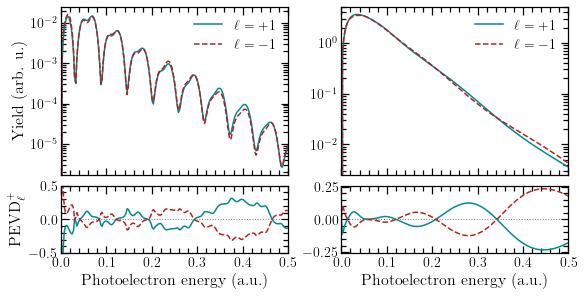

In [270]:
fig, axs = plt.subplots(2, 2, facecolor='white', figsize=(8, 4), sharex='all', constrained_layout=True,
                        gridspec_kw={'height_ratios': [2.5, 1]})
axs[0, 0].plot(E_lst, spec1_2, c='darkcyan', label=r'$\ell=+1$')
axs[0, 0].plot(E_lst, spec2_2, c='firebrick', ls='--', label=r'$\ell=-1$')
axs[0, 1].plot(E_lst, spec1_3*1e3, c='darkcyan', ls='-', label=r'$\ell=+1$')
axs[0, 1].plot(E_lst, spec2_3*1e3, c='firebrick', ls='--', label=r'$\ell=-1$')
axs[0, 1].legend(frameon=False)
axs[0, 0].minorticks_on()
axs[0, 0].set_ylabel(r'Yield (arb. u.)')
axs[0, 0].set_xlim(E_lst[0], E_lst[-1])
axs[0, 0].set_yscale('log')
axs[0, 0].legend(frameon=False)

axs[1, 0].set_xlabel(r'Photoelectron energy (a.u.)')
res = 2 * (spec1_2 - spec2_2) / (spec1_2 + spec2_2 + 1e-30)
axs[1, 0].plot(E_lst, res, c='darkcyan')
axs[1, 0].plot(E_lst, -res, ls='--', c='firebrick')
axs[1, 0].minorticks_on()

axs[0, 1].set_yscale('log')
axs[1, 1].set_xlabel(r'Photoelectron energy (a.u.)')

res2 = 2 * (spec1_3 - spec2_3) / (spec1_3 + spec2_3 + 1e-30)
axs[1, 1].plot(E_lst, res2, c='darkcyan')
axs[1, 1].plot(E_lst, -res2, ls='--', c='firebrick')

axs[1, 1].set_xlim(E_lst[0], E_lst[-1])
axs[1, 1].minorticks_on()
axs[1, 0].set_ylabel(r'PEVD$^+_\ell$')
axs[1, 0].set_ylim(-0.5, 0.5)
axs[1, 0].axhline(0, ls=':', zorder=-5, color='gray', lw=1)
axs[1, 1].axhline(0, ls=':', zorder=-5, color='gray', lw=1)

plt.savefig('ATI_spectre_fencone.eps', format='eps')

plt.show()

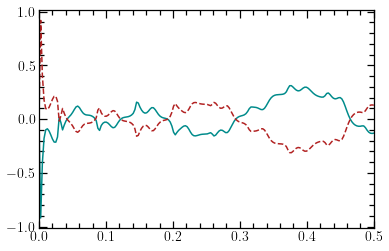

In [245]:
plt.figure(facecolor='white')
res = 2 * (spec1_2 - spec2_2) / (spec1_2 + spec2_2 + 1e-30)
plt.plot(E_lst, res, c='darkcyan')
plt.plot(E_lst, -res, ls='--', c='firebrick')
plt.xlim(E_lst[0], E_lst[-1])
plt.minorticks_on()

## Partially aligned orientation averaging

In [146]:
from sympy.physics.wigner import wigner_3j
def a(l, mu, m1, m2):
    return 2*(-1)**(m2 - m1) * float(wigner_3j(2, l, mu, 0, m2, -m2)) * float(wigner_3j(2, l, mu, 0, m1, -m1)) + (1 if l == mu else 0)/(2*l + 1)

In [147]:
N = 2
dp = 4. / 125 #450
px_lst = np.arange(0.01, 1, dp)
pz_lst = np.arange(-1.4, 1.4, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)
sfa_lm = sfa_lin.SFALinearPulse(Ip, Up, omega, N, np.pi/2.0, 'single_clm')
l_max = clm_array.shape[1]

M_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')

count = 0
for l in range(l_max):
    for mu in range(l_max):
        for m1 in range(-l, l + 1):
            for m2 in range(-l, l + 1):
                sgn1 = 0 if m1 >= 0 else 1
                lm_lst1 = [l, m2]
                lm_lst2 = [mu, m2]
                clm1 = clm_array[sgn1, l, abs(m1)]
                clm2 = clm_array[sgn1, mu, abs(m1)]
                if np.abs(clm1) == 0 or np.abs(clm2) == 0:
                    continue
                M1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array(lm_lst1))))
                M2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array(lm_lst2))))
                a_coeff = a(l, mu, m1, m2)
                if np.isnan(np.abs(np.sum(M1))**2) or np.isnan(np.abs(np.sum(M2))**2) or np.isnan(a_coeff) or abs(a_coeff) == 0:
                    continue
                M_avg += clm1 * np.conjugate(clm2) * a_coeff * np.array(M1) * np.conjugate(np.array(M2))
                print(f'Number {count}', end='\r')
                #print(f'a = {a(l, mu, m1, m2)}')
                #print(np.sum(M_avg)**2)
                count += 1

In [148]:
OAM_lst = [1, 2]
threshold = 0.125e-2
M_p_avg = np.zeros((len(OAM_lst), px_grd.shape[0], px_grd.shape[1]), dtype='complex')
M_m_avg = np.zeros((len(OAM_lst), px_grd.shape[0], px_grd.shape[1]), dtype='complex')
PEVD_lst = []
count = 0

for i, OAM in enumerate(OAM_lst):
    for l in range(l_max):
        for mu in range(l_max):
            for m in range(-l, l + 1):
                sgn = 0 if m >= 0 else 1
                clm1 = clm_array[sgn, l, abs(m)]
                clm2 = clm_array[sgn, mu, abs(m)]
                if np.abs(clm1) == 0 or np.abs(clm2) == 0:
                    continue
                Mp1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([l, OAM]))))
                Mp2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([mu, OAM]))))
                M_p_avg[i] += clm1 * np.conjugate(clm2) * a(l, mu, OAM, m) * np.array(Mp1) * np.conjugate(np.array(Mp2))

                Mm1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([l, -OAM]))))
                Mm2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([mu, -OAM]))))
                M_m_avg[i] += clm1 * np.conjugate(clm2) * a(l, mu, -OAM, m) * np.array(Mm1) * np.conjugate(np.array(Mm2))
                print(f'Number {count} w/ OAM ±{OAM}', end='\r')
                count += 1

for Mp, Mm in zip(M_p_avg, M_m_avg):
    PEVD = 2*((Mp - Mm)/(Mp + Mm + 1e-30))
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Mp > np.max(Mp * threshold)
    filter_list2 = Mm > np.max(Mm * threshold)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    PEVD_lst.append(PEVD)


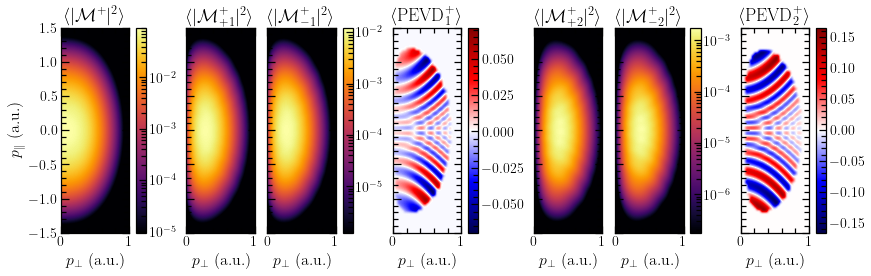

In [151]:
M_avg = np.real(M_avg)
M_p_avg = np.real(M_p_avg)
M_m_avg = np.real(M_m_avg)
#PEVD_lst = np.real(PEVD_lst)
M_max = np.max(np.real(M_avg))


fig, ax = plt.subplots(1, 7, figsize=(12, 6), facecolor='white', sharey='all', constrained_layout=True)
im1 = ax[0].imshow(M_avg, cmap='inferno', norm=LogNorm(vmax=M_max, vmin=M_max*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[0].set_ylabel(r'$p_\parallel$ (a.u.)')
ax[0].set_title(r'$\langle|\mathcal{M}^+|^2\rangle$')

im2 = ax[1].imshow(M_p_avg[0], cmap='inferno', norm=LogNorm(vmax=np.max(M_p_avg[0]), vmin=np.max(M_p_avg[0])*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[1].set_title(r'$\langle|\mathcal{M}^+_{+1}|^2\rangle$')

im3 = ax[2].imshow(M_m_avg[0], cmap='inferno', norm=LogNorm(vmax=np.max(M_m_avg[0]), vmin=np.max(M_m_avg[0])*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[2].set_title(r'$\langle|\mathcal{M}^+_{-1}|^2\rangle$')

im4 = ax[3].imshow(np.real(PEVD_lst[0]), cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[3].set_title(r'$\langle\text{PEVD}^+_1\rangle$')

im5 = ax[4].imshow(M_p_avg[1], cmap='inferno', norm=LogNorm(vmax=np.max(M_p_avg[1]), vmin=np.max(M_p_avg[1])*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[4].set_title(r'$\langle|\mathcal{M}^+_{+2}|^2\rangle$')

im6 = ax[5].imshow(M_m_avg[1], cmap='inferno', norm=LogNorm(vmax=np.max(M_m_avg[1]), vmin=np.max(M_m_avg[1])*1e-4),
                   interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[5].set_title(r'$\langle|\mathcal{M}^+_{-2}|^2\rangle$')

im7 = ax[6].imshow(np.real(PEVD_lst[1]), cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[6].set_title(r'$\langle\text{PEVD}^+_2\rangle$')

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[2])
cbar = fig.colorbar(im4, ax=ax[3])
cbar.minorticks_on()
fig.colorbar(im6, ax=ax[5])
cbar2 = fig.colorbar(im7, ax=ax[6])
cbar2.minorticks_on()

for axi in ax:
    axi.set_xlabel(r'$p_\perp$ (a.u.)')
    axi.minorticks_on()
# 0.15, 0.2

## CEP-averaging

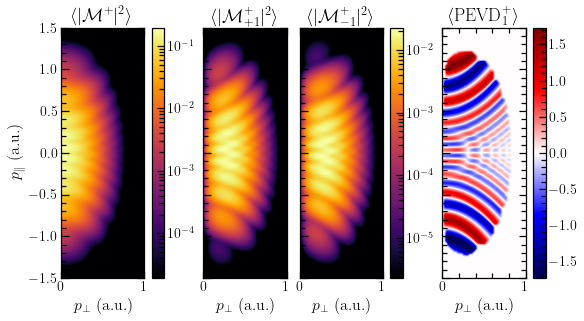

In [152]:
CEP_lst = np.linspace(0, 2 * np.pi, 7)[:-1]
#CEP_lst = [np.pi/2]

threshold = 0.125 * 1e-2

N = 2
dp = 4. / 175  #450
px_lst = np.arange(0.01, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

M_CEP_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')
M_p1_CEP_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')
M_m1_CEP_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')
for CEP_i in CEP_lst:
    sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP_i, 'asymp')
    M_CEP_avg += np.abs(np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))) ** 2

    sfa.OAM = 1
    M_p1_CEP_avg += np.abs(
        np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))) ** 2

    sfa.OAM = -1
    M_m1_CEP_avg += np.abs(
        np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))) ** 2

M_CEP_avg /= len(CEP_lst)
M_p1_CEP_avg /= len(CEP_lst)
M_m1_CEP_avg /= len(CEP_lst)

PEVD = 2 * ((M_p1_CEP_avg - M_m1_CEP_avg) / (M_p1_CEP_avg + M_m1_CEP_avg))
PEVD = np.nan_to_num(PEVD, nan=0)
filter_list1 = M_p1_CEP_avg > np.max(M_p1_CEP_avg * threshold)
filter_list2 = M_m1_CEP_avg > np.max(M_m1_CEP_avg * threshold)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(combined_filter)] = 0
M_avg = np.real(M_CEP_avg)
M_p1_avg = np.real(M_p1_CEP_avg)
M_m1_avg = np.real(M_m1_CEP_avg)
PEVD = np.real(PEVD)
M_max = np.max(np.real(M_avg))

fig, ax = plt.subplots(1, 4, figsize=(8, 6), facecolor='white', sharey='all', constrained_layout=True)
im1 = ax[0].imshow(M_avg, cmap='inferno', interpolation='bicubic', extent=(0, 1, -1.5, 1.5),
                   norm=LogNorm(vmax=M_max, vmin=M_max * 1e-4))
ax[0].set_ylabel(r'$p_\parallel$ (a.u.)')
ax[0].set_title(r'$\langle|\mathcal{M}^+|^2\rangle$')

im2 = ax[1].imshow(M_p1_avg, cmap='inferno', norm=LogNorm(vmax=np.max(M_p1_avg), vmin=np.max(M_p1_avg) * 1e-4),
                   interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[1].set_title(r'$\langle|\mathcal{M}^+_{+1}|^2\rangle$')

im3 = ax[2].imshow(M_m1_avg, cmap='inferno', norm=LogNorm(vmax=np.max(M_m1_avg), vmin=np.max(M_m1_avg) * 1e-4),
                   interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[2].set_title(r'$\langle|\mathcal{M}^+_{-1}|^2\rangle$')

im4 = ax[3].imshow(PEVD, cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[3].set_title(r'$\langle\text{PEVD}^+_1\rangle$')

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[2])
cbar = fig.colorbar(im4, ax=ax[3])
cbar.minorticks_on()

for axi in ax:
    axi.set_xlabel(r'$p_\perp$ (a.u.)')
    axi.minorticks_on()
#0.75

In [125]:
print(np.min(PEVD))
print(np.max(PEVD))

-1.4691192796334047
1.4621071701395534


## CEP and orientation averaging

In [ ]:
''' PARAMETERS AND SETUP '''
CEP_lst = np.linspace(0, 2*np.pi, 7)[:-1]
threshold = 0.125*1e-2

N = 2
dp = 4. / 175#450
px_lst = np.arange(0.01, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

M_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')

''' FIRST DO THE TOTAL AVERAGE '''

print('Total average in progress')
l_max = clm_array.shape[1]
M_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')

count = 0
for CEP_i in CEP_lst:
    sfa_lm = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP_i, 'single_clm')
    for l in range(l_max):
        for mu in range(l_max):
            for m1 in range(-l, l + 1):
                for m2 in range(-l, l + 1):
                    sgn1 = 0 if m1 >= 0 else 1
                    lm_lst1 = [l, m2]
                    lm_lst2 = [mu, m2]
                    clm1 = clm_array[sgn1, l, abs(m1)]
                    clm2 = clm_array[sgn1, mu, abs(m1)]
                    if np.abs(clm1) == 0 or np.abs(clm2) == 0:
                        continue
                    M1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array(lm_lst1))))
                    M2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array(lm_lst2))))
                    M_avg += clm1 * np.conjugate(clm2) * a(l, mu, m1, m2) * np.array(M1) * np.conjugate(np.array(M2))
    count +=  1
    print(f'CEP avg. {count} of {len(CEP_lst)} done.')
M_avg /= len(CEP_lst)

Total average in progress
CEP avg. 1 of 6 done.
CEP avg. 2 of 6 done.
CEP avg. 3 of 6 done.


In [ ]:
''' OAM AVERAGES '''
M_p1_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')
M_m1_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')
M2_p1_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')
M2_m1_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')
OAM1 = 1
OAM2 = -1
count = 0
for CEP_i in CEP_lst:
    sfa_lm = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP_i, 'single_clm')
    for l in range(l_max):
        for mu in range(l_max):
            for m1 in range(-l, l + 1):
                sgn = 0 if m1 >= 0 else 1
                clm1 = clm_array[sgn, l, abs(m1)]
                clm2 = clm_array[sgn, mu, abs(m1)]
                if np.abs(clm1) == 0 or np.abs(clm2) == 0:
                    continue
                Mp1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([l, OAM1]))))
                Mp2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([mu, OAM1]))))
                M_p1_avg += clm1 * np.conjugate(clm2) * a(l, mu, OAM1, m1) * np.array(Mp1) * np.conjugate(np.array(Mp2))

                Mm1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([l, OAM2]))))
                Mm2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([mu, OAM2]))))
                M_m1_avg += clm1 * np.conjugate(clm2) * a(l, mu, OAM2, m1) * np.array(Mm1) * np.conjugate(np.array(Mm2))

                Mp1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([l, 2]))))
                Mp2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([mu, 2]))))
                M2_p1_avg += clm1 * np.conjugate(clm2) * a(l, mu, 2, m1) * np.array(Mp1) * np.conjugate(np.array(Mp2))

                Mm1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([l, -2]))))
                Mm2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([mu, -2]))))
                M2_m1_avg += clm1 * np.conjugate(clm2) * a(l, mu, -2, m1) * np.array(Mm1) * np.conjugate(np.array(Mm2))
    count +=  1
    print(f'CEP avg. {count} of {len(CEP_lst)} done.')
M_p1_avg /= len(CEP_lst)
M_m1_avg /= len(CEP_lst)

PEVD = 2*((M_p1_avg - M_m1_avg)/(M_p1_avg + M_m1_avg))
PEVD = np.nan_to_num(PEVD, nan=0)
filter_list1 = M_p1_avg > np.max(M_p1_avg * threshold)
filter_list2 = M_m1_avg > np.max(M_m1_avg * threshold)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(combined_filter)] = 0

M2_p1_avg /= len(CEP_lst)
M2_m1_avg /= len(CEP_lst)

PEVD2 = 2*((M2_p1_avg - M2_m1_avg)/(M2_p1_avg + M2_m1_avg))
PEVD2 = np.nan_to_num(PEVD2, nan=0)
filter_list1 = M2_p1_avg > np.max(M2_p1_avg * threshold)
filter_list2 = M2_m1_avg > np.max(M2_m1_avg * threshold)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD2[np.logical_not(combined_filter)] = 0

In [ ]:
M_avg = np.real(M_avg)
M_p1_avg = np.real(M_p1_avg)
M_m1_avg = np.real(M_m1_avg)
PEVD = np.real(PEVD)
M_max = np.max(np.real(M_avg))
M2_p1_avg = np.real(M2_p1_avg)
M2_m1_avg = np.real(M2_m1_avg)
PEVD2 = np.real(PEVD2)

fig, ax = plt.subplots(1, 7, figsize=(12, 4), facecolor='white', sharey='all', constrained_layout=True)
im1 = ax[0].imshow(M_avg, cmap='inferno', interpolation='bicubic', extent=(0, 1, -1.5, 1.5), norm=LogNorm(vmax=M_max, vmin=M_max*1e-4))
ax[0].set_ylabel(r'$p_\parallel$ (a.u.)')
ax[0].set_title(r'$\langle|\mathcal{M}^+|^2\rangle$')

im2 = ax[1].imshow(M_p1_avg, cmap='inferno', norm=LogNorm(vmax=np.max(M_p1_avg), vmin=np.max(M_p1_avg)*1e-4), interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[1].set_title(r'$\langle|\mathcal{M}^+_{+1}|^2\rangle$')

im3 = ax[2].imshow(M_m1_avg, cmap='inferno', norm=LogNorm(vmax=np.max(M_m1_avg), vmin=np.max(M_m1_avg)*1e-4), interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[2].set_title(r'$\langle|\mathcal{M}^+_{-1}|^2\rangle$')

im4 = ax[3].imshow(PEVD, cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[3].set_title(r'$\langle\text{PEVD}^+_1\rangle$')

im5 = ax[4].imshow(M2_p1_avg, cmap='inferno', norm=LogNorm(vmax=np.max(M2_p1_avg), vmin=np.max(M2_p1_avg)*1e-4), interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[4].set_title(r'$\langle|\mathcal{M}^+_{+2}|^2\rangle$')

im6 = ax[5].imshow(M2_m1_avg, cmap='inferno', norm=LogNorm(vmax=np.max(M2_m1_avg), vmin=np.max(M2_m1_avg)*1e-4), interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[5].set_title(r'$\langle|\mathcal{M}^+_{-2}|^2\rangle$')

im7 = ax[6].imshow(PEVD2, cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[6].set_title(r'$\langle\text{PEVD}^+_2\rangle$')

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[2])
cbar = fig.colorbar(im4, ax=ax[3])
cbar.minorticks_on()
fig.colorbar(im6, ax=ax[5])
cbar2 = fig.colorbar(im7, ax=ax[6])
cbar2.minorticks_on()

for axi in ax:
    axi.set_xlabel(r'$p_\perp$ (a.u.)')
    axi.minorticks_on()

plt.savefig('CHBrClF_avg.png', dpi=350)

In [293]:
np.sqrt(Ip/(2 * Up))

1.0308866439755986

## Stationary phase plots

In [118]:
Ip = abs(output.saved_orbitals[output.HOMO][0])
#Ip = 0.18374702734839
kappa = np.sqrt(2*Ip)
omega = 0.057     # Frequency of light
Up = 0.11         # Ponderomotive potential
CEP = np.pi/2
N = 2

sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, N, np.pi, 'asymp')

n_t = 2000
tr_range = [0.1, 2 * N * np.pi / omega]
ti_range = [0.1, 55]
t_real = np.linspace(tr_range[0], tr_range[1], n_t)
t_imag = np.linspace(ti_range[0], ti_range[1], n_t)

In [113]:
S_mat = np.zeros((n_t, n_t), dtype='complex')
DS_mat = np.zeros((n_t, n_t), dtype='complex')
for i, t_r in enumerate(t_real):
    for j, t_i in enumerate(t_imag):
        S_mat[i, j] += np.exp(1j * sfa.S(0.5, 0.0, 0.0, t_r + 1j * t_i))
        DS_mat[i, j] += sfa.DS(0.5, 0.0, 0.0, t_r + 1j * t_i)

ts = sfa.TimesGen(0.5, 0.0, 0.0)

In [137]:
DS = lambda t: sfa.DS(0.5, 0.0, 0.0, t)
S = lambda t: np.real(1j*sfa.S(0.5, 0.0, 0.0, t))
DDS = lambda t: sfa.DDS(0.5, 0.0, 0.0, t)
def gradient_descent(ts, dt, n_iters, sgn, sgn2=1):
    t = np.array([np.real(ts), np.imag(ts)])
    steps = []
    steps.append(t.copy())
    for _ in range(n_iters):
        t_num = t[0] + 1.j*t[1]
        delta_t = -sgn2*sgn*((S(t_num + sgn*dt) - S(t_num)) / dt + 1j*(S(t_num + sgn*1.j*dt) - S(t_num)) / dt)
        t += np.array([np.real(delta_t), np.imag(delta_t)])
        steps.append(t.copy())
    return np.array(steps)
steps_x = []
steps_y = []
for s in ts:
    for sgn in [1, -1]:
        steps = gradient_descent(s, 0.05, 230, 1, sgn2=sgn)
        x, y = steps[:,0], steps[:,1]
        steps_x.append(x)
        steps_y.append(y)
        steps = gradient_descent(s, 0.05, 230, -1, sgn2=sgn)
        x, y = steps[:,0], steps[:,1]
        steps_x.append(x)
        steps_y.append(y)


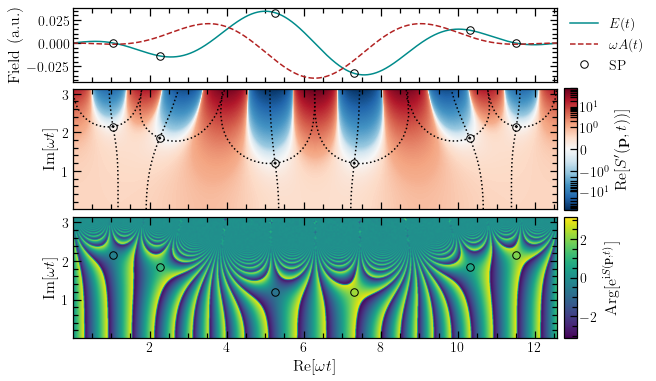

In [139]:
import matplotlib as mpl
fig, ax = plt.subplots(3, 1, facecolor='white', figsize=(9, 5.1), sharex='all', constrained_layout=True,
                       gridspec_kw={'height_ratios': [0.6, 1, 1]})#, 'width_ratios': [1]})
times = []
for i, t_r in enumerate(t_real):
    for j, t_i in enumerate(t_imag):
        if 0 <= np.abs(DS_mat[i, j]) <= 0.1:
            times.append([t_r, t_i])
times = np.array(times)
re_mat = np.flip(np.real(DS_mat).T, 0)

ax[0].plot(omega*t_real, [sfa.Ef(t) for t in t_real], c='darkcyan', label=r'$E(t)$')
ax[0].plot(omega*t_real, [omega*sfa.Af(t) for t in t_real], c='firebrick', ls='--', label=r'$\omega A(t)$')
#ax[0].set_xlim(tr_range[0], tr_range[1])
ax[0].plot(omega*np.real(ts), [sfa.Ef(t) for t in np.real(ts)], ls='none', marker='o', ms=7.5, c='k', fillstyle='none', label='SP')
ax[0].legend(frameon=False, ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))

for sx, sy in zip(steps_x, steps_y):
    ax[1].plot(omega*sx, omega*sy, 'k:')

im0 = ax[1].imshow(re_mat, norm=mpl.colors.SymLogNorm(vmax=np.max(re_mat), vmin=np.min(re_mat), linthresh=1, linscale=1),
                   #norm=MidpointNormalize(vmax=np.max(np.real(DS_mat)), vmin=np.min(np.real(DS_mat))),
                   cmap='RdBu_r', extent=(omega*tr_range[0], omega*tr_range[1], omega*ti_range[0], omega*ti_range[1]))
ax[1].plot(omega*np.real(ts), omega*np.imag(ts), ls='none', marker='o', ms=7.5, c='k', fillstyle='none')
cbar0 = plt.colorbar(im0, ax=ax[1], label=r'Re$[S^\prime(\mathbf{p},t))]$', aspect=10, shrink=0.99, pad=-0.175)
ax[1].set_xlim(omega*tr_range[0], omega*tr_range[1])
ax[1].set_ylim(omega*ti_range[0], omega*ti_range[1])
mat = np.angle(S_mat)
mat = np.flip(mat.T, 0)
im1 = ax[2].imshow(mat, cmap='viridis', extent=(omega*tr_range[0], omega*tr_range[1], omega*ti_range[0], omega*ti_range[1]), interpolation='bicubic')
ax[2].plot(omega*np.real(ts), omega*np.imag(ts), ls='none', marker='o', ms=7.5, c='k', fillstyle='none')
cbar1 = plt.colorbar(im1, ax=ax[2], label=r'Arg$[\text{e}^{\text{i}S(\mathbf{p},t)}]$', aspect=10, shrink=0.99, pad=-0.175)
cbar1.minorticks_on()
ax[2].set_xlim(omega*tr_range[0], omega*tr_range[1])
ax[2].set_xlabel(r'Re$[\omega t]$')
#cbar1.set_ticks([])

for x in ax:
    x.minorticks_on()
    if x is ax[0]:
        x.set_ylabel('Field (a.u.)')
    else:
        x.set_ylabel(r'Im$[\omega t]$')
plt.savefig('SPA.png', dpi=350)
plt.show()

In [99]:
ts*2

[(18.498385437469256+37.70188105587149j),
 (39.72407971066889+32.48012488835374j),
 (92.24691796656911+21.048939092624035j),
 (128.21572439060932+21.048939092624014j),
 (180.73856264650956+32.48012488835369j),
 (201.9642569197092+37.701881055871404j),
 (18.498385437469256+37.70188105587149j),
 (39.72407971066889+32.48012488835374j),
 (92.24691796656911+21.048939092624035j),
 (128.21572439060932+21.048939092624014j),
 (180.73856264650956+32.48012488835369j),
 (201.9642569197092+37.701881055871404j)]